<a href="https://colab.research.google.com/github/mikhpo/ds-for-non-ds/blob/16-%D0%BE%D1%82%D1%80%D0%B0%D0%B7%D0%B8%D1%82%D1%8C-%D0%BD%D0%BE%D0%B2%D1%83%D1%8E-%D1%81%D1%82%D1%80%D0%B0%D1%82%D0%B5%D0%B3%D0%B8%D1%8E-%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8-%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85-%D0%B2-google-colab/notebooks/credit_scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Решение задачи кредитного скоринга

Группа 1:
*   Поляков Михаил Юрьевич
*   Томилин Виктор Александрович
*   Макаров Никита Игоревич

[Репозиторий проекта](https://github.com/mikhpo/ds-for-non-ds) в GitHub.





## Импорт библиотек и настройка среды

Данные хранятся в базе данных PostgreSQL в Yandex Cloud. Для подключения к PostgreSQL-кластеру в Yandex Cloud необходимо загрузить SSL-сертификат.

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-06-05 11:55:34--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-06-05 11:55:34 (1004 MB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



Установка библиотеки CatBoost, не входящей в стандартную среду выполнения Google Colab.

In [4]:
!pip install catboost shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 46.2 MB/s eta 0:00:00


Все библиотеки импортированы в данном блоке в следующем порядке:
1. Модули стандартной библиотеки
2. Сторонние модули из каталога PyPI

In [5]:
import warnings

import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score, 
    confusion_matrix,
    precision_score, 
    recall_score,
    f1_score, 
    roc_auc_score,
    classification_report,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from catboost import CatBoostClassifier, Pool
import shap
from IPython.display import display

In [6]:
warnings.filterwarnings("ignore")
plt.style.use("default")
shap.initjs()

## Получение и сохранение данных

Получение данных из таблицы `credit_scoring` в базе данных `db_clients` из PostgreSQL-кластера в Yandex Cloud.

In [8]:
def read_sql_data():
  """
  Создание подключения к базе данных. Чтение данных из таблицы 
  SQL-запросом и создание датафрейма Pandas.
  """
  conn = psycopg2.connect("""
      host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
      port=6432
      sslmode=verify-full
      dbname=db_clients
      user=mlhs_student
      password=mlhs_student
      target_session_attrs=read-write
  """)
  query = "SELECT * from public.credit_scoring"
  data = pd.read_sql_query(query, conn)
  conn.close()
  return data

data = read_sql_data()

Сохранение данных в формате CSV.

In [9]:
data.to_csv("credit_scoring.csv", index=False)

## Разведочный анализ и подготовка данных

Описание данных:
* SeriousDlqin2yrs: Клиент имел просрочку 90 и более дней - целевая переменная.
* RevolvingUtilizationOfUnsecuredLines: Общий баланс средств (total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits).
* age: Возраст заемщика
* NumberOfTime30-59DaysPastDueNotWorse: Сколько раз за последние 2 года наблюдалась просрочка 30-59 дней.
* DebtRatio: Ежемесячные расходы (платеж по долгам, алиментам, расходы на проживания) деленные на месячный доход.
* MonthlyIncome: Ежемесячный доход.
* NumberOfOpenCreditLinesAndLoans: Количество открытых кредитов (напрмер, автокредит или ипотека) и кредитных карт.
* NumberOfTimes90DaysLate: Сколько раз наблюдалась просрочка (90 и более дней).
* NumberRealEstateLoansOrLines: Количество кредитов (в том числе под залог жилья)
* RealEstateLoansOrLines: Закодированное количество кредитов (в том числе под залог жилья) - чем больше код буквы, тем больше кредитов
* NumberOfTime60-89DaysPastDueNotWorse: Сколько раз за последние 2 года заемщик задержал платеж на 60-89 дней.
* NumberOfDependents: Количество иждивенцев на попечении (супруги, дети и др).
* GroupAge: закодированная возрастная группа - чем больше код, тем больше возраст.

In [10]:
display(data)
row_count = len(data)
col_count = len(data.columns)
print(f"Набор данных содержит {row_count} строк и {col_count} столбцов")

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,0,0.221813,43.0,0,0.527888,3280.0,7,0,0,2.0,A,c
1,0,0.602794,25.0,0,0.065868,333.0,2,0,0,0.0,A,b
2,1,0.025656,38.0,0,0.475841,3000.0,7,0,0,2.0,A,c
3,0,0.075427,32.0,0,0.085512,7916.0,6,0,0,0.0,A,b
4,0,0.046560,58.0,0,0.241622,2416.0,9,0,0,0.0,A,d
...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.977899,63.0,0,517.000000,NaN,5,0,1,0.0,A,d
149996,0,0.025449,58.0,0,0.253855,15500.0,7,0,0,2.0,A,d
149997,0,0.058001,83.0,0,0.013997,5000.0,6,0,0,0.0,A,e
149998,0,0.071273,42.0,0,0.008638,6945.0,3,0,0,1.0,A,c


Набор данных содержит 150000 строк и 12 столбцов


### Описательная статистика набора данных

Технические параметры набора данных.

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   135155 non-null  float64
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 9   NumberOfDependents                    146076 non-null  float64
 10  RealEstateLoansOrLines                150000 non-null  object 
 11  

Общая описательная статистика.

In [12]:
data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,135155.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.293618,0.421033,353.005076,6.670221e+03,8.452760,0.265973,0.240387,0.757222
std,0.249746,249.755371,14.772577,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,98.000000,20.000000


Статистика категориальных признаков.

In [13]:
data.describe(include="object")

,RealEstateLoansOrLines,GroupAge
count,150000,150000
unique,5,5
top,A,d
freq,140048,47268


Изучим сбалансированность набора данных по признаку **age**.

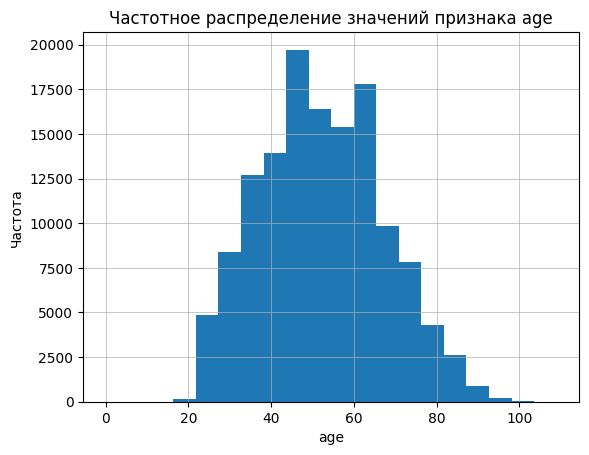

In [14]:
plt.hist(data["age"], bins=20)
plt.xlabel("age")
plt.ylabel("Частота")
plt.xticks(rotation="horizontal")
plt.title("Частотное распределение значений признака age")
plt.grid(linewidth=0.5)
plt.show()

Частотное распределение представляет собой колоколообразную кривую с пиком в центре диапазона значений, из чего можно сделать вывод, что набор данных достаточно хорошо сбалансирован по возрастному признаку.

### Распределение целевой переменной

Целевая переменная - поле **SeriousDlqin2yrs** - имел ли клиент просрочку 90 или более дней. Представляет собой категориальный признак, принимающий значения 1 и 0.

In [15]:
TARGET_FEATURE = "SeriousDlqin2yrs"

In [16]:
pivot_data = pd.pivot_table(data, index=TARGET_FEATURE, aggfunc={TARGET_FEATURE: "count"})
pivot_data.rename(columns={TARGET_FEATURE: "count"}, inplace=True)
pivot_data["share"] = pivot_data["count"]/len(data)
display(pivot_data)

,count,share
SeriousDlqin2yrs,,
0,139974,0.93316
1,10026,0.06684


Наблюдается существенный дисбаланс в распределении целевых значений. Визуализируем этот дисбаланс.

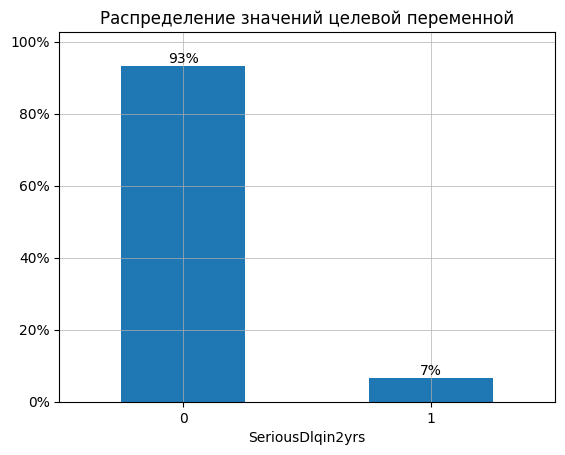

In [17]:
fig, ax = plt.subplots()
ax = pivot_data["share"].plot(kind="bar")
ax.grid(linewidth=0.5)
ax.bar_label(ax.containers[0], fmt="{:.0%}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title("Распределение значений целевой переменной")
plt.xticks(rotation="horizontal")
plt.margins(0.1, 0.1)
plt.show()

Дисбаланс классов целевых значений необходимо будет учесть при разработке модели машинного обучения.

### Обработка пропусков

Определим столбцы с пропусками.

In [18]:
data.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                     14845
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
RealEstateLoansOrLines                      0
GroupAge                                    0
dtype: int64

Пропуски обнаружены в полях **age**, **MonthlyIncome**, **NumberOfDependents**. Значения в этих полях числовые - следовательно, их можно заменить средними и медианными значениями. Воспользуемся медианными значениями, чтобы избежать влияния статистических выбросов.

In [19]:
for field in ("age", "MonthlyIncome", "NumberOfDependents"):
  median = data[field].median()
  print(f"Медианное значение поля {field} составляет {median}")
  data[field] = data[field].fillna(median)

Медианное значение поля age составляет 52.0
Медианное значение поля MonthlyIncome составляет 5400.0
Медианное значение поля NumberOfDependents составляет 0.0


In [20]:
data.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
RealEstateLoansOrLines                  0
GroupAge                                0
dtype: int64

Теперь пропуски отсутствуют.

### Обработка ошибочных значений

Проверим распределение значений у текстовых признаков.

In [21]:
def print_categorical_values_counts(df):
  """
  Вывести на экран подсчет значений категориальных признаков.
  """
  for field in ("RealEstateLoansOrLines", "GroupAge"):
    value_counts = df[field].value_counts()
    print(value_counts)
    print()

print_categorical_values_counts(data)

A    140048
B      8470
C      1388
D        84
E        10
Name: RealEstateLoansOrLines, dtype: int64

d    47268
e    42930
c    42458
b    17343
a        1
Name: GroupAge, dtype: int64



Все значения текстовых признаков представляют собой буквенный код. Значение a признака GroupAge встречается в наборе данных только один раз. Удалим строку с этим значением из набора данных.

In [22]:
data = data[data["GroupAge"] != "a"]
print_categorical_values_counts(data)

A    140047
B      8470
C      1388
D        84
E        10
Name: RealEstateLoansOrLines, dtype: int64

d    47268
e    42930
c    42458
b    17343
Name: GroupAge, dtype: int64



### Взаимосвязь признаков

Проанализируем взаимосвязь между признаками, построив матрицу корреляций.

In [23]:
corr = data.corr()
corr.style.background_gradient(cmap="coolwarm")

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.001802,-0.110127,0.125587,-0.007602,-0.017151,-0.029669,0.117175,0.102261,0.046871
RevolvingUtilizationOfUnsecuredLines,-0.001802,1.000000,-0.005430,-0.001313,0.003961,0.006513,-0.011281,-0.001061,-0.001048,0.001193
age,-0.110127,-0.005430,1.000000,-0.059947,0.022804,0.025312,0.140705,-0.057995,-0.054376,-0.204352
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.001313,-0.059947,1.000000,-0.006542,-0.008370,-0.055312,0.983603,0.987006,-0.004591
DebtRatio,-0.007602,0.003961,0.022804,-0.006542,1.000000,-0.018006,0.049565,-0.008320,-0.007533,-0.044475
MonthlyIncome,-0.017151,0.006513,0.025312,-0.008370,-0.018006,1.000000,0.086949,-0.010500,-0.009252,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,-0.011281,0.140705,-0.055312,0.049565,0.086949,1.000000,-0.079985,-0.071077,0.074030
NumberOfTimes90DaysLate,0.117175,-0.001061,-0.057995,0.983603,-0.008320,-0.010500,-0.079985,1.000000,0.992796,-0.011962
NumberOfTime60-89DaysPastDueNotWorse,0.102261,-0.001048,-0.054376,0.987006,-0.007533,-0.009252,-0.071077,0.992796,1.000000,-0.012678
NumberOfDependents,0.046871,0.001193,-0.204352,-0.004591,-0.044475,0.066314,0.074030,-0.011962,-0.012678,1.000000


Наблюдается сильная взаимная корреляция между признаками **NumberOfTimes90DaysLate**, **NumberOfTime60-89DaysPastDueNotWorse** и **NumberOfTime30-59DaysPastDueNotWorse**. Лишние признаки необходимо удалить. Решение о том, какие признаки удалить, можно принимать на основании коэффициента корреляции каждого признака и целевой переменной.

Определим корреляцию признаков с целевой переменной.

In [24]:
def create_corr_data(df):
  """
  Сформировать датафрейм, показывающий корреляцию каждого 
  признака в исходном датафрейме к целевой переменной.
  """
  corr_data = pd.DataFrame()
  for col in data.columns:
    if col != TARGET_FEATURE:
      try:
          new_row = {
              "col": col, 
              "corr": np.corrcoef(data[col], data[TARGET_FEATURE])[0][1]
          }
          corr_data = corr_data.append(new_row, ignore_index=True)
      except:
          pass
  return corr_data

corr_data = create_corr_data(data)
display(corr_data)

,col,corr
0,RevolvingUtilizationOfUnsecuredLines,-0.001802
1,age,-0.110127
2,NumberOfTime30-59DaysPastDueNotWorse,0.125587
3,DebtRatio,-0.007602
4,MonthlyIncome,-0.017151
5,NumberOfOpenCreditLinesAndLoans,-0.029669
6,NumberOfTimes90DaysLate,0.117175
7,NumberOfTime60-89DaysPastDueNotWorse,0.102261
8,NumberOfDependents,0.046871


Удалим признаки **NumberOfTimes90DaysLate** и **NumberOfTime60-89DaysPastDueNotWorse** из набора данных, так как оставшийся признак **NumberOfTime30-59DaysPastDueNotWorse** имеет большую корреляцию с целевой переменной. 

Также удалим признаки **RevolvingUtilizationOfUnsecuredLines** и **DebtRatio**, так как они показывают крайне низкую корреляцию с целевой переменной.

In [25]:
data = data.drop([
  "NumberOfTimes90DaysLate",
  "NumberOfTime60-89DaysPastDueNotWorse", 
  "RevolvingUtilizationOfUnsecuredLines", 
  "DebtRatio", 
], axis=1)

In [26]:
corr_data = create_corr_data(data)
display(corr_data)

,col,corr
0,age,-0.110127
1,NumberOfTime30-59DaysPastDueNotWorse,0.125587
2,MonthlyIncome,-0.017151
3,NumberOfOpenCreditLinesAndLoans,-0.029669
4,NumberOfDependents,0.046871


In [27]:
corr = data.corr()
corr.style.background_gradient(cmap="coolwarm")

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
SeriousDlqin2yrs,1.000000,-0.110127,0.125587,-0.017151,-0.029669,0.046871
age,-0.110127,1.000000,-0.059947,0.025312,0.140705,-0.204352
NumberOfTime30-59DaysPastDueNotWorse,0.125587,-0.059947,1.000000,-0.008370,-0.055312,-0.004591
MonthlyIncome,-0.017151,0.025312,-0.008370,1.000000,0.086949,0.066314
NumberOfOpenCreditLinesAndLoans,-0.029669,0.140705,-0.055312,0.086949,1.000000,0.074030
NumberOfDependents,0.046871,-0.204352,-0.004591,0.066314,0.074030,1.000000


Теперь не наблюдается признаков с ярко выраженной взаимной корреляцией.

### Преобразование данных для обучения

Сформируем отдельно матрицу признаков и вектор целевой переменной.

In [28]:
y = data[TARGET_FEATURE]
x = data.drop(columns=[TARGET_FEATURE])
display(x)

,age,NumberOfTime30-59DaysPastDueNotWorse,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfDependents,RealEstateLoansOrLines,GroupAge
0,43.0,0,3280.0,7,2.0,A,c
1,25.0,0,333.0,2,0.0,A,b
2,38.0,0,3000.0,7,2.0,A,c
3,32.0,0,7916.0,6,0.0,A,b
4,58.0,0,2416.0,9,0.0,A,d
...,...,...,...,...,...,...,...
149995,63.0,0,5400.0,5,0.0,A,d
149996,58.0,0,15500.0,7,2.0,A,d
149997,83.0,0,5000.0,6,0.0,A,e
149998,42.0,0,6945.0,3,1.0,A,c


Для обучения модели необходимо разделить набор данных на две части: для обучения и для тестирования. Разобъем набор данных при помощи функции train_test_split, входящей в библиотеку sklearn. Набор данных для обучения будет составлять 70% от всех данных, для тестирования - 30%.

In [29]:
test_size = 0.3
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=13)

Визуализируем распределение соотношение размеров данных для обучения и тестирования.

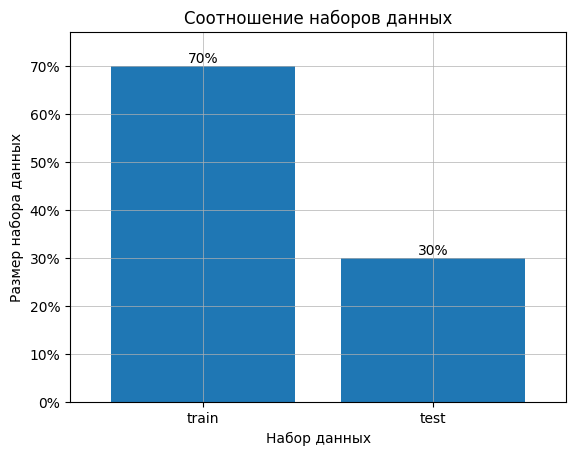

In [30]:
fig, ax = plt.subplots()
sets = ["train", "test"]
counts = [1 - test_size, test_size]
ax.bar(sets, counts)
ax.grid(linewidth=0.5)
ax.bar_label(ax.containers[0], fmt="{:.0%}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_xlabel("Набор данных")
ax.set_ylabel("Размер набора данных")
ax.set_title("Соотношение наборов данных")
plt.xticks(rotation="horizontal")
plt.margins(0.1, 0.1)
plt.show()

Набор данных содержит числовые непрерывные данные и категориальные данные. Непрерывные числовые данные необходимо нормализовать, а категориальные данные необходимо закодировать. Сначала определим перечень признаков, содержащих числовые непрерывные данные, и перечень признаков, содержащих категориальные данные. Категориальные признаки в данном наборе данных - это столбцы с типом данных object (текстовые данные). Числовые признаки - это все остальные признаки, кроме категориальных

In [31]:
categorical_features = [column for column in x.columns if x[column].dtype == "object"]
numerical_features = [column for column in x.columns if column not in categorical_features]

print(f"Категориальные признаки: {', '.join(categorical_features)}")
print(f"Числовые признаки: {', '.join(numerical_features)}")

Категориальные признаки: RealEstateLoansOrLines, GroupAge
Числовые признаки: age, NumberOfTime30-59DaysPastDueNotWorse, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberOfDependents


Нам необходимо нормализовать числовые признаки в связи с тем, что они изменяются в разных масштабах. Для нормализации будем использовать класс  StandardScaler библиотеки sklearn.

Что касается категориальных признаков, то их можно закодировать методом One-Hot Encoding, реализация которого также имеется в библиотеке sklearn.

In [32]:
numerical_preprocessor = Pipeline(steps=[
    ("scaling", StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("encoding", OneHotEncoder(handle_unknown="ignore"))
])

column_transformer = ColumnTransformer([
    ("numerical", numerical_preprocessor, numerical_features),
    ("categorical", categorical_preprocessor, categorical_features),
])

В представлении датафрейма преобразованные значения выглядят следующим образом.

In [33]:
pd.DataFrame(column_transformer.fit_transform(x))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.660733,-0.100418,-0.243473,-0.282315,1.140539,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-1.944416,-0.100418,-0.472092,-1.253953,-0.666119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-1.017312,-0.100418,-0.265194,-0.282315,1.140539,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.445206,-0.100418,0.116175,-0.476642,-0.666119,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.409002,-0.100418,-0.310499,0.106341,-0.666119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149994,0.765580,-0.100418,-0.079009,-0.670970,-0.666119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149995,0.409002,-0.100418,0.704520,-0.282315,1.140539,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
149996,2.191894,-0.100418,-0.110040,-0.476642,-0.666119,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
149997,-0.732049,-0.100418,0.040848,-1.059625,0.237210,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


## Выбор алгоритмов классификации

Далее будет для решения задачи кредитного скоринга будет протестировано несколько алгоритмов машинного обучения.


### Логистическая регрессия

В связи с тем, что перед нами стоит задача бинарной классификации, мы можем использовать для ее решения модель логистической регресии. Логистическая регрессия моделирует зависимость выходной переменной от набора входных переменных при помощи логистической функции. В общем виде формулу логистической функции можно записать в виде:

\begin{align}
  a(x) = \sigma(w_0 + w_1x_1 + w_2x_2 + ...) ,
\end{align}
где:
- $a(x)$ - целевой признак
- $x_1, x_2, x_n$ - факторные признаки
- $w_0, w_1, w_n$ - веса признаков
- $\sigma$ - сигмоидальная функция

Далее обучим модель логистической регрессии.

In [34]:
logistic_regression = Pipeline(steps=[
    ("column_transformer", column_transformer),
    ("classifier", LogisticRegression())
])
logistic_regression.fit(x_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'MonthlyIncome',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'NumberOfDependents']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['RealEstateLoansOrLines',
                                                   'GroupAge'])])),
                ('classifier', LogisticRegression())])

Получим предсказания на тестовом наборе данных.

In [35]:
logistic_regression_predictions = logistic_regression.predict(x_test)
logistic_regression_probabilities = logistic_regression.predict_proba(x_test)

Теперь применим обученную модель логистической регрессии для предсказания целевой переменной на тестовом наборе данных и проанализуем основные метрики.

In [36]:
logistic_regression_report = classification_report(y_test, logistic_regression_predictions)
print(f"Основные метрики логистической регрессии:\n{logistic_regression_report}")

Основные метрики логистической регрессии:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41939
           1       0.50      0.01      0.02      3061

    accuracy                           0.93     45000
   macro avg       0.72      0.51      0.49     45000
weighted avg       0.90      0.93      0.90     45000



**Accuracy** показывает долю правильных предсказаний в общей массе предсказаний. Accuracy принимает значения от 0 до 1. Чем больше значение - тем лучше. Accuracy вычисляется по следующей формуле:

\begin{align}
  accuracy = \frac{TN + TP}{TN + FP + FN + TP} ,
\end{align}

где:
- TP - количество истинно положительных
- FN - количество ложно отрицательных
- TN - количество истинно отрицательных
- FP - количество ложно положительных

In [37]:
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_predictions)
print(f"Accuracy (доля правильных предсказаний) модели логистической регрессии: {logistic_regression_accuracy}")

Accuracy (доля правильных предсказаний) модели логистической регрессии: 0.9319777777777778


Мы получили высокое значение accuracy на данной модели. Однако нужно иметь в виду несбалансированность исходного набора данных по целевым классам. 93% значений целевой переменной в наборе данных соответствуют одному из классов, что необходимо учитывать при интерпретации полученного значения accuracy.

Для анализа доли правильных ответов классификаторов, обученныых на несбалансированном наборе данных. можно использовать фукнцию `balanced_accuracy_score` библиотеки `sklearn`. 

\begin{align}
  balanced-accuracy = \frac{1}{2} * ( \frac{TP}{TP + FN} + \frac{TN}{TN + FP} ) ,
\end{align}
где:
- TP - количество истинно положительных
- FN - количество ложно отрицательных
- TN - количество истинно отрицательных
- FP - количество ложно положительных



In [38]:
logistic_regression_balanced_accuracy = balanced_accuracy_score(
    y_test, 
    logistic_regression_predictions, 
    adjusted=False
)
print(f"Balanced accuracy модели логистической регрессии: {logistic_regression_balanced_accuracy}")

Balanced accuracy модели логистической регрессии: 0.5059055061527851


Матрица ошибок сопоставляет предсказанные значения с фактическими значениями для каждого класса.

Матрица ошибок (confusion_matrix) модели логистической регрессии:


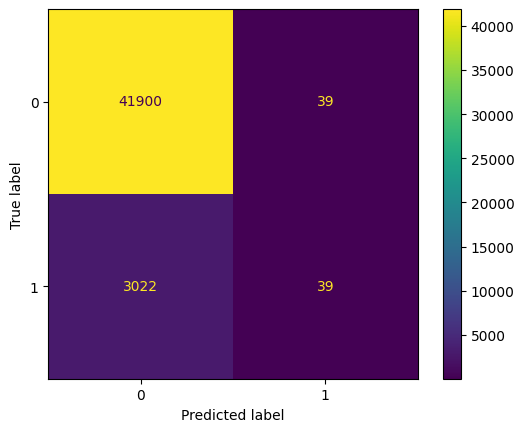

In [39]:
logistic_regression_confusion = confusion_matrix(y_test, logistic_regression_predictions, labels=logistic_regression.classes_)
print(f"Матрица ошибок (confusion_matrix) модели логистической регрессии:")
logistic_regression_confusion_display = ConfusionMatrixDisplay(logistic_regression_confusion, display_labels=logistic_regression.classes_)
logistic_regression_confusion_display.plot()
plt.show()

Из матрицы ошибок можно сделать вывод, что модель логистической регрессии не смогла корректно определить большую часть должников, которые вышли на просрочку.

Далее рассчитаем точность (**precision**) модели логистической регрессии. Precision отражает способность классификатора не принимать за положительное то наблюдение, которое является отрицательным. Точность принимает значения в диапазоне от 0 до 1. Чем больше precision - тем лучше. Точность рассчитывается по следующей формуле:
\begin{align}
  precision = \frac{TP}{TP+NP} ,
\end{align}
где:
- TP - количество истинно положительных
- NP - количество ложно положительных



In [40]:
logistic_regression_precision = precision_score(y_test, logistic_regression_predictions)
print(f"Точность (precision) модели логистической регрессии: {logistic_regression_precision}")

Точность (precision) модели логистической регрессии: 0.5


Текущее значение метрики precision означает среднюю адекватность в истинно положительных предсказаниях.

Далее рассчитаем полноту (**recall**) модели логистической регрессии. Recall отражает способность классификатора находить истинно положительные значения. Полнота принимает значения в диапазоне от 0 до 1. Чем больше recall - тем лучше. Полнота рассчитывается по следующей формуле:
\begin{align}
  recall = \frac{TP}{TP+FN} ,
\end{align}
где:
- TP - количество истинно положительных
- FN - количество ложно отрицательных


In [41]:
logistic_regression_recall = recall_score(y_test, logistic_regression_predictions)
print(f"Recall (полнота обнаружения целевой перменной) модели логистической регрессии: {logistic_regression_recall}")

Recall (полнота обнаружения целевой перменной) модели логистической регрессии: 0.01274093433518458


Текущее значение recall модели логистической регрессии показывает слабую способность модели в обнаружении истинно положительных значений. С учетом специфики задачи это указывает на то, что модель плохо решает поставленную задачу: нам важно определить как можно больше должников, вышедших на просрочку, чтобы минимизировать потери.

Рассчиатаем метрику **F1**. F1 представляет собой среднее гармоническое значение точности и полноты. F1 актуально применять тогда, когда Precision и Recall одинаково важны. F1 принимает значения от 0 до 1, чем больше - тем лучше. F1 рассчитывается по следующей формуле:

\begin{align}
  F1 = \frac{1}{\frac{1}{Precision} + \frac{1}{Recall}}
\end{align}

In [42]:
logistic_regression_f1 = f1_score(y_test, logistic_regression_predictions)
print(f"F1 (среднее гармоническое точности и полноты) модели логистической регрессии: {logistic_regression_f1}")

F1 (среднее гармоническое точности и полноты) модели логистической регрессии: 0.024848677922905387


Рассчитываем площадь под ROC-кривой. Кривая ошибок ROC (Receiver Operating Characteristic) позволяет оценить качество работы классификатора на различных значниях дискриминационного порога. 

AUC-ROC (площадь под кривой ошибок) модели логистической регрессии: 0.6677246403491751


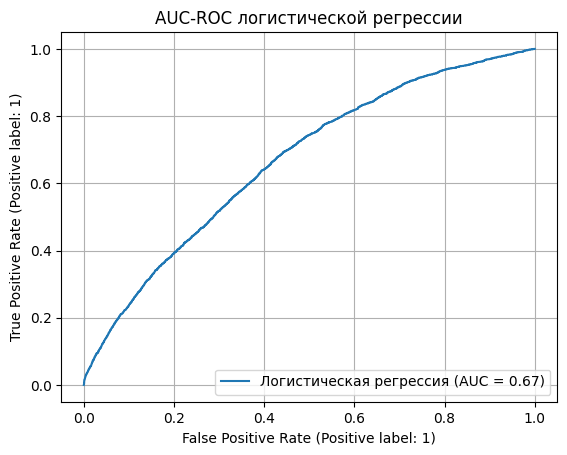

In [43]:
logistic_regression_roc_auc = roc_auc_score(y_test, logistic_regression_probabilities[:,1])
print(f"AUC-ROC (площадь под кривой ошибок) модели логистической регрессии: {logistic_regression_roc_auc}")
RocCurveDisplay.from_predictions(y_test, logistic_regression_probabilities[:,1], name="Логистическая регрессия")
plt.title("AUC-ROC логистической регрессии")
plt.grid()
plt.show()

Кривая показывает, что модель не существенно превосходит случайные предсказания.

Модель присваивает классу 0 (у клиента не будет просрочки) всегда большие вероятности. Мы можем изменить пороговое значение для перевода вероятности в классы со стандартного значения 0.5.



In [44]:
logistic_regression_probabilities_past_due = logistic_regression_probabilities[:,1]
logistic_regression_adjusted = logistic_regression_probabilities_past_due > 0.2

Матрица ошибок (confusion_matrix) модели логистической регрессии после изменения порога вероятности:


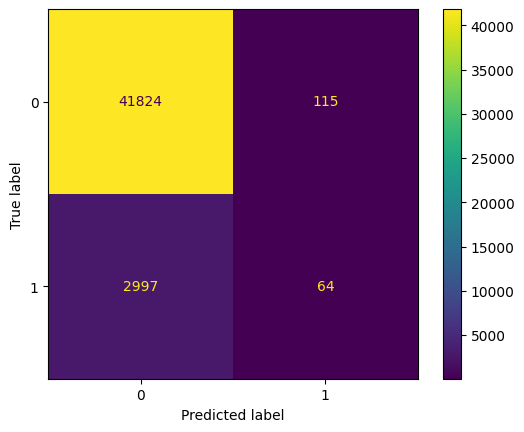

In [45]:
logistic_regression_confusion_adjusted = confusion_matrix(y_test, logistic_regression_adjusted, labels=logistic_regression.classes_)
print(f"Матрица ошибок (confusion_matrix) модели логистической регрессии после изменения порога вероятности:")
logistic_regression_adjusted_confusion_display = ConfusionMatrixDisplay(logistic_regression_confusion_adjusted, display_labels=logistic_regression.classes_)
logistic_regression_adjusted_confusion_display.plot()
plt.show()

In [46]:
logistic_regression_adjusted_report = classification_report(y_test, logistic_regression_adjusted)
print(f"Основные метрики классификатора (логистической регрессии) после изменения порога:\n{logistic_regression_adjusted_report}")

Основные метрики классификатора (логистической регрессии) после изменения порога:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41939
           1       0.36      0.02      0.04      3061

    accuracy                           0.93     45000
   macro avg       0.65      0.51      0.50     45000
weighted avg       0.89      0.93      0.90     45000



Снижение порогого значения вероятности класса 1 позволило существенно повысить полноту обнаружения дефолтов, однако снизилась общая меткость модели.

### Дерево решений

Дерево решений - это метод представления правил принятия решений в виде структуры, состоящей из узлов (node) и листьев (leaf). Узлы содержат решающие правила и проверяют данные на выполнение условий этих правил. Листы являются конечными узлами деревьев, для задач классификации листья представляют собой один из классов, ассоциируемых с узлом.

Далее обучим модель дерева решений.

In [47]:
decision_tree = Pipeline(steps=[
    ("column_transformer", column_transformer),
    ("classifier", DecisionTreeClassifier())
])
decision_tree.fit(x_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'MonthlyIncome',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'NumberOfDependents']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['RealEstateLoansOrLines',
                                                   'GroupAge'])])),
                ('classifier', DecisionTreeClassifier())])

Визуализируем первые узлы полученного дерева решений.

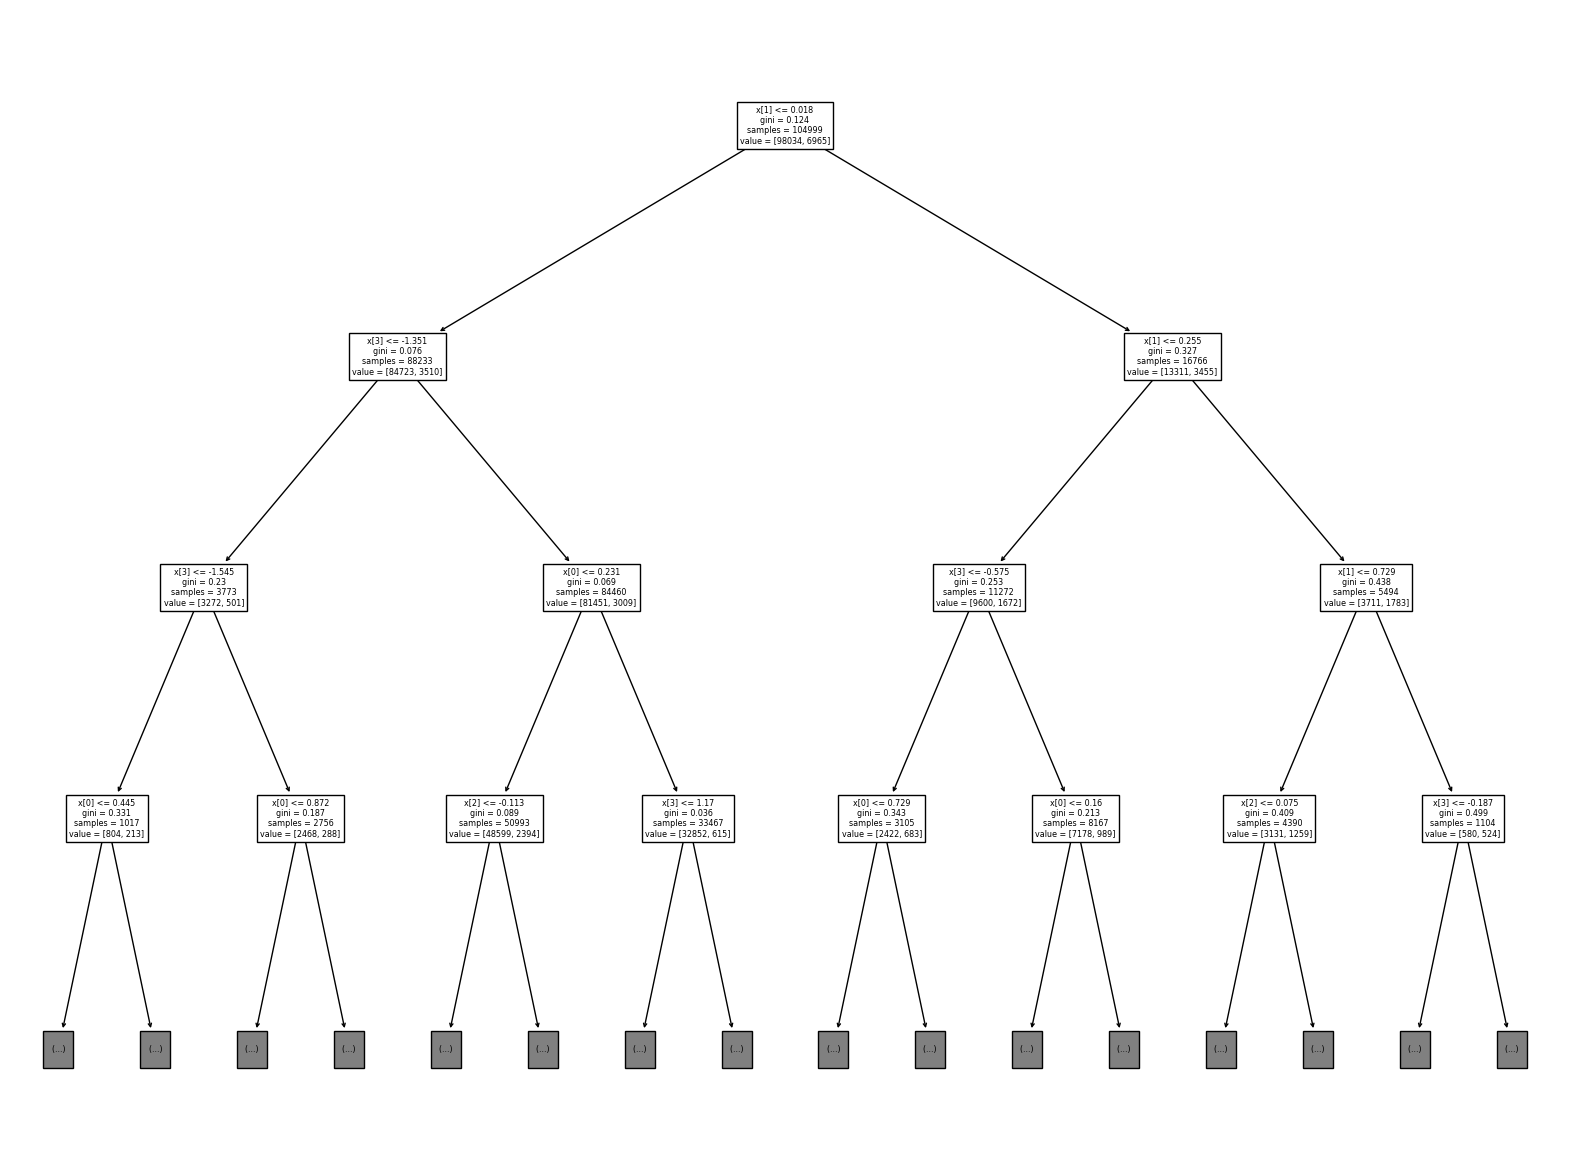

In [48]:
plt.figure(figsize=(20, 15))
plot_tree(decision_tree.named_steps["classifier"], max_depth=3)
plt.show()

Получим предсказания на тестовом наборе данных.

In [49]:
decision_tree_predictions = decision_tree.predict(x_test)
decision_tree_probabilities = decision_tree.predict_proba(x_test)

Отобразим основные метрики классификатора.

In [50]:
decision_tree_report = classification_report(y_test, decision_tree_predictions)
print(f"Основные метрики дерева решений:\n{decision_tree_report}")

Основные метрики дерева решений:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     41939
           1       0.17      0.18      0.17      3061

    accuracy                           0.89     45000
   macro avg       0.56      0.56      0.56     45000
weighted avg       0.89      0.89      0.89     45000



In [51]:
decision_tree_accuracy = accuracy_score(y_test, decision_tree_predictions)
print(f"Accuracy (доля правильных предсказаний) модели дерева решений: {decision_tree_accuracy}")

Accuracy (доля правильных предсказаний) модели дерева решений: 0.8865777777777778


In [52]:
decision_tree_balanced_accuracy = balanced_accuracy_score(y_test, decision_tree_predictions, adjusted=False)
print(f"Balanced accuracy модели дерева решений: {decision_tree_balanced_accuracy}")

Balanced accuracy модели дерева решений: 0.5572603195666668


Матрица ошибок (confusion_matrix) модели дерева решений:


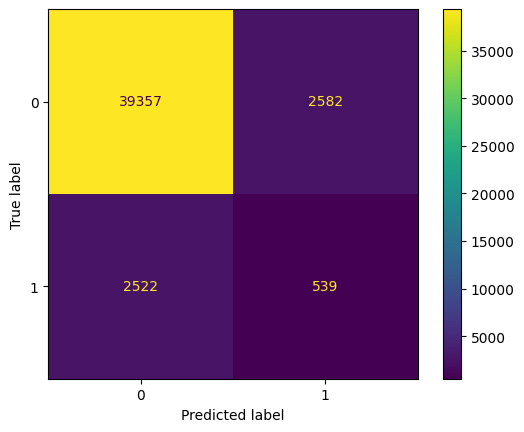

In [53]:
decision_tree_confusion = confusion_matrix(y_test, decision_tree_predictions, labels=decision_tree.classes_)
print(f"Матрица ошибок (confusion_matrix) модели дерева решений:")
decision_tree_confusion_display = ConfusionMatrixDisplay(decision_tree_confusion, display_labels=decision_tree.classes_)
decision_tree_confusion_display.plot()
plt.show()

In [54]:
decision_tree_confusion_precision = precision_score(y_test, decision_tree_predictions)
print(f"Точность (precision) модели дерева решений: {decision_tree_confusion_precision}")

Точность (precision) модели дерева решений: 0.17270105735341237


In [55]:
decision_tree_confusion_recall = recall_score(y_test, decision_tree_predictions)
print(f"Recall (полнота обнаружения целевой перменной) модели дерева решений: {decision_tree_confusion_recall}")

Recall (полнота обнаружения целевой перменной) модели дерева решений: 0.17608624632473047


AUC-ROC (площадь под кривой ошибок) модели дерева решений: 0.5592016941205635


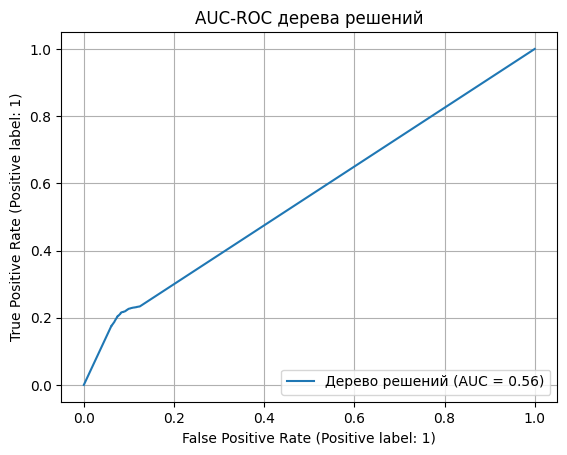

In [56]:
decision_tree_roc_auc = roc_auc_score(y_test, decision_tree_probabilities[:,1])
print(f"AUC-ROC (площадь под кривой ошибок) модели дерева решений: {decision_tree_roc_auc}")
RocCurveDisplay.from_predictions(y_test, decision_tree_probabilities[:,1], name="Дерево решений")
plt.title("AUC-ROC дерева решений")
plt.grid()
plt.show()

Мы видим, что, хотя модель дерева решений демонстрирует меньшую эффективность по сравнению с моделью логистической регрессии, и ей присущи те же недостатки: небольшая полнота предсказания истинно положительных наблюдений - то есть, недостаточная адекватность задаче обнаружения должников, выходящих на дефолт по обязательствам.

Аналогично подходу с логистической регрессией снизим дискриминационный порог до 20% и сравним метрики по сравнению со стандартным дискриминационным порогом.

In [57]:
decision_tree_probabilities_past_due = decision_tree_probabilities[:,1]
decision_tree_adjusted = decision_tree_probabilities_past_due > 0.2

In [58]:
decision_tree_adjusted_report = classification_report(y_test, decision_tree_adjusted)
print(f"Основные метрики дерева решений после изменения порога вероятности:\n{decision_tree_adjusted_report}")

Основные метрики дерева решений после изменения порога вероятности:
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     41939
           1       0.17      0.20      0.18      3061

    accuracy                           0.88     45000
   macro avg       0.55      0.56      0.56     45000
weighted avg       0.89      0.88      0.88     45000



Матрица ошибок (confusion_matrix) модели дерева решений после изменения порога вероятности:


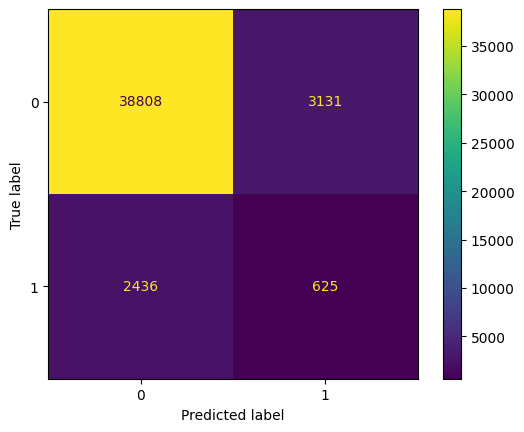

In [59]:
decision_tree_confusion_adjusted = confusion_matrix(y_test, decision_tree_adjusted, labels=decision_tree.classes_)
print(f"Матрица ошибок (confusion_matrix) модели дерева решений после изменения порога вероятности:")
decision_tree_adjusted_confusion_display = ConfusionMatrixDisplay(decision_tree_confusion_adjusted,  display_labels=decision_tree.classes_)
decision_tree_adjusted_confusion_display.plot()
plt.show()

Мы видим, что удалось добиться незначительного повышения полноты определения истинно положительных предсказаний за счет понижения меткости предсказаний в целом.

### Градиентный бустинг

Градиентный бустинг является разновидностью ансамблевых методов машинного обучения. Он строит композицию решающих дереьев путем последовательного уменьшения ошибки текущего ансамбля.

Инициализируем модель CatBoost со следующими параметрами:

- Количество деревьев: 60
- Функция потерь: Logloss
- Метрика для переобучения: AUC

In [60]:
cat_boost = Pipeline(steps=[
    ("column_transformer", column_transformer),
    ("classifier", CatBoostClassifier(
        iterations=60,
        loss_function="Logloss",
        verbose=False
    ))
])
cat_boost.fit(x_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaling',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'NumberOfTime30-59DaysPastDueNotWorse',
                                                   'MonthlyIncome',
                                                   'NumberOfOpenCreditLinesAndLoans',
                                                   'NumberOfDependents']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['RealEstateLoansOrLines',
                                                   'GroupAge'])])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7fed4fe23790>)])

Обучение классификатора.

Теперь применим классификатор для получения предсказаний значений целевого класса и вероятностей.

In [61]:
cat_boost_predictions = cat_boost.predict(x_test)
cat_boost_probabilities = cat_boost.predict_proba(x_test)

Отобразим на графике зависимость между площадью AUC и количеством деревьев.

AUC-ROC (площадь под кривой ошибок) модели градиентного бустинга: 0.7886342159381012


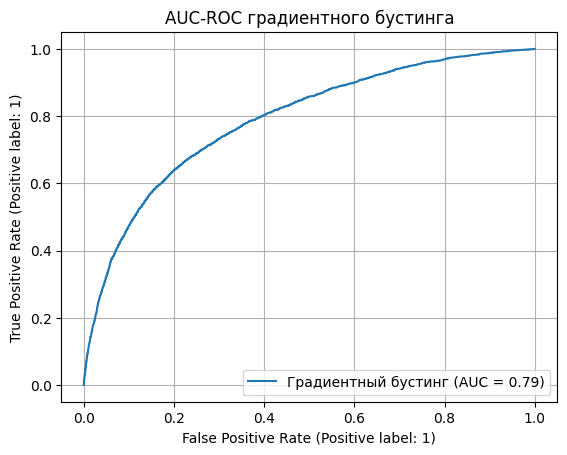

In [62]:
cat_boost_roc_auc = roc_auc_score(y_test, cat_boost_probabilities[:,1])
print(f"AUC-ROC (площадь под кривой ошибок) модели градиентного бустинга: {cat_boost_roc_auc}")
RocCurveDisplay.from_predictions(y_test, cat_boost_probabilities[:,1], name="Градиентный бустинг")
plt.title("AUC-ROC градиентного бустинга")
plt.grid()
plt.show()

Изучим основные метрики классификатора.

In [63]:
cat_boost_report = classification_report(y_test, cat_boost_predictions)
print(f"Основные метрики градиентного бустинга:\n{cat_boost_report}")

Основные метрики градиентного бустинга:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41939
           1       0.49      0.04      0.08      3061

    accuracy                           0.93     45000
   macro avg       0.71      0.52      0.52     45000
weighted avg       0.90      0.93      0.90     45000



Со стандартным дискриминационным порогом модель градиентного бустинга показывает Recall ниже, чем дерево решений и логистическая регрессия.

Матрица ошибок (confusion_matrix) модели градиентного бустинга:


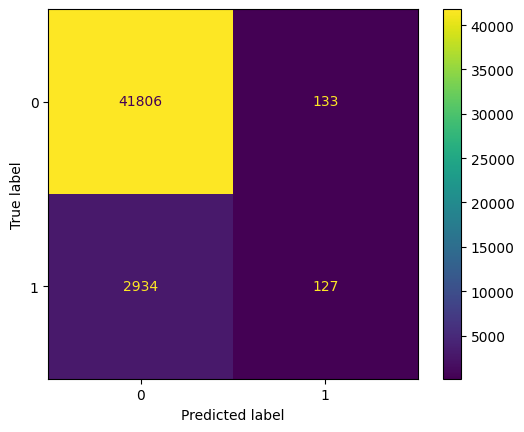

In [64]:
cat_boost_confusion = confusion_matrix(y_test, cat_boost_predictions, labels=decision_tree.classes_)
print(f"Матрица ошибок (confusion_matrix) модели градиентного бустинга:")
cat_boost_confusion_display = ConfusionMatrixDisplay(cat_boost_confusion, display_labels=decision_tree.classes_)
cat_boost_confusion_display.plot()
plt.show()

Это указывает на то, что модель с такими параметрами плохо подходит для определения должников, выходящих на просрочку. Снизим вероятность целевого класса до 20%.

In [65]:
cat_boost_probabilities_past_due = cat_boost_probabilities[:,1]
cat_boost_adjusted_predictions = cat_boost_probabilities_past_due > 0.2

In [66]:
cat_boost_adjusted_report = classification_report(y_test, cat_boost_adjusted_predictions)
print(f"Основные метрики градиентного бустинга:\n{cat_boost_adjusted_report}")

Основные метрики градиентного бустинга:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     41939
           1       0.31      0.35      0.33      3061

    accuracy                           0.90     45000
   macro avg       0.63      0.65      0.64     45000
weighted avg       0.91      0.90      0.91     45000



Матрица ошибок (confusion_matrix) модели градиентного бустинга после снижения порога вероятности:


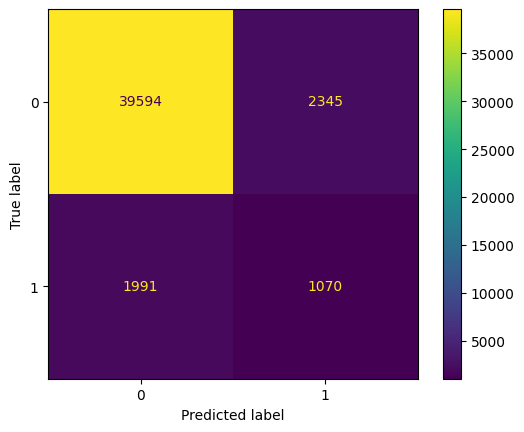

In [67]:
cat_boost_adjusted_confusion = confusion_matrix(y_test, cat_boost_adjusted_predictions, labels=decision_tree.classes_)
print(f"Матрица ошибок (confusion_matrix) модели градиентного бустинга после снижения порога вероятности:")
cat_boost_adjusted_confusion_display = ConfusionMatrixDisplay(cat_boost_adjusted_confusion, display_labels=decision_tree.classes_)
cat_boost_adjusted_confusion_display.plot(values_format="")
plt.show()

 После снижения дискриминационного порога до 0.2 мы смогли получить существенное улучшениие Recall истинно положительных.

### Сравнение моделей

Для выбора модели сравним их по AUC-ROC.

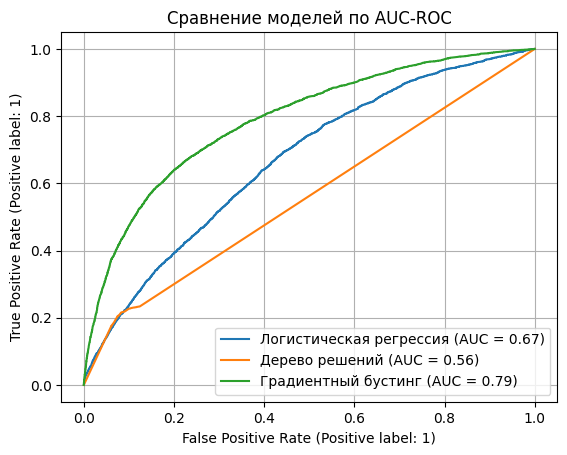

In [68]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, logistic_regression.decision_function(x_test), ax=ax, name="Логистическая регрессия")
RocCurveDisplay.from_predictions(y_test, decision_tree_probabilities[:,1], ax=ax, name="Дерево решений")
RocCurveDisplay.from_predictions(y_test, cat_boost_probabilities[:,1], ax=ax, name="Градиентный бустинг",)
plt.title("Сравнение моделей по AUC-ROC")
plt.legend()
plt.grid()
plt.show()

Модель градиентного бустинга CatBoost демонстрирует наибольшую метрику AUC-ROC, поэтому далее будем оптимизировать модель градиентного бустинга CatBoost.

## Оптимизация модели CatBoost

В предыдущем разделе мы определили, что CatBoost показывает наибольшую эффективность среди сравниваемых алгоритмов машинного обучения, если сравнивать по метрике AUC-ROC. Далее мы оптимизируем модель CatBoost для более эффективного решения поставленной задачи - кредитного скоринга.

#### Стандартный подход

In [69]:
# Заново разобъем набор данных на набор для тестирования и набор для обучения.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=13)

# Определить индексы столбцов, под которыми находятся категориальные признаки.
categorical_features_indices = np.where(x.dtypes == object)[0]

# Сгруппируем наборы данных для тестирования и обучения.
train_pool = Pool(x_train, y_train, cat_features=categorical_features)
test_pool = Pool(x_test, y_test, cat_features=categorical_features)

# Задать параметры модели CatBoost.
params = {
    "iterations": 200,
    "learning_rate": 0.1,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "random_seed": 42,
    "logging_level": "Verbose",
    "use_best_model": True,
}

# Инициализировать модель CatBoost с заданными выше параметрами.
model = CatBoostClassifier(**params)

Ранее мы применяли алгоритм CatBoost вместе с пайплайном, разработанным при помощи библиотеки `sklearn`:

1.   Масштабировать значения числовых признаков
2.   Закодировать значения категориальных признаков
3.   Обучить модель на заранее обработанных данных 



Теперь мы не будем заранее обрабатывать данные, позволив библиотеке CatBoost автоматически выполнить необходимые преобразования.

In [70]:
# Построить ансамбль и определить оптимальную итерацию.
model.fit(train_pool, eval_set=test_pool, verbose=True, plot=False)

0:	test: 0.6855718	best: 0.6855718 (0)	total: 90.9ms	remaining: 18.1s
1:	test: 0.7533176	best: 0.7533176 (1)	total: 175ms	remaining: 17.4s
2:	test: 0.7581670	best: 0.7581670 (2)	total: 274ms	remaining: 18s
3:	test: 0.7612827	best: 0.7612827 (3)	total: 364ms	remaining: 17.9s
4:	test: 0.7629243	best: 0.7629243 (4)	total: 440ms	remaining: 17.2s
5:	test: 0.7636940	best: 0.7636940 (5)	total: 564ms	remaining: 18.2s
6:	test: 0.7712816	best: 0.7712816 (6)	total: 737ms	remaining: 20.3s
7:	test: 0.7724571	best: 0.7724571 (7)	total: 861ms	remaining: 20.7s
8:	test: 0.7717652	best: 0.7724571 (7)	total: 937ms	remaining: 19.9s
9:	test: 0.7753081	best: 0.7753081 (9)	total: 1.01s	remaining: 19.3s
10:	test: 0.7745783	best: 0.7753081 (9)	total: 1.16s	remaining: 19.9s
11:	test: 0.7757650	best: 0.7757650 (11)	total: 1.3s	remaining: 20.4s
12:	test: 0.7766673	best: 0.7766673 (12)	total: 1.5s	remaining: 21.5s
13:	test: 0.7781082	best: 0.7781082 (13)	total: 1.6s	remaining: 21.2s
14:	test: 0.7786658	best: 0.778

Применим модель для получения предсказаний и вероятностей, после чего пострим стандартный классификацонный отчет.

In [71]:
# Получить предсказания модели и вероятности.
model_predictions = model.predict(x_test)
model_probabilities = model.predict_proba(x_test)

# Построить классификационный отчет.
model_report = classification_report(y_test, model_predictions)
print(f"Основные метрики модели CatBoost:\n{model_report}")

Основные метрики модели CatBoost:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41939
           1       0.51      0.03      0.06      3061

    accuracy                           0.93     45000
   macro avg       0.72      0.52      0.51     45000
weighted avg       0.91      0.93      0.90     45000



Проанализируем площадь под кривой ошибок.

Проанализируем значимость признаков.

In [72]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,NumberOfTime30-59DaysPastDueNotWorse,42.009793
1,age,26.256861
2,NumberOfOpenCreditLinesAndLoans,14.237104
3,MonthlyIncome,9.427565
4,NumberOfDependents,3.660854
5,RealEstateLoansOrLines,2.919863
6,GroupAge,1.487959


Из анализа значимости признаков можно сделать вывод, что модель дает наименьшие веса категориальных признакам `GroupAge` и `RealEstateLoansOrLines`. Если модель считает эти признаки наименее значимыми, то попробуем удалить эти признаки совсем. После этого переобучим модель, оставив параметры прежними.

### Удаление категориальных признаков

In [73]:
x_numerical = x.drop(columns=categorical_features)

In [74]:
# Заново разобъем набор данных на набор для тестирования и набор для обучения.
x_train_numerical, x_test_numerical, y_train, y_test = train_test_split(
    x_numerical, y, test_size=0.3, random_state=13
)

# Сгруппируем наборы данных для тестирования и обучения.
train_pool_numerical = Pool(x_train_numerical, y_train)
test_pool_numerical = Pool(x_test_numerical, y_test)

# Инициализировать модель CatBoost с заданными выше параметрами.
model_numerical = CatBoostClassifier(**params)

# Построить ансамбль и определить оптимальную итерацию.
print("AUC модели CatBoost после удаления категориальных признаков:")
model_numerical.fit(
    train_pool_numerical, 
    eval_set=test_pool_numerical, 
    verbose=False, 
    plot=False
)

AUC модели CatBoost после удаления категориальных признаков:

bestTest = 0.7862264198
bestIteration = 112

Shrink model to first 113 iterations.


In [75]:
model_numerical_predictions = model_numerical.predict(x_test_numerical)
model_numerical_probabilities = model_numerical.predict_proba(x_test_numerical)
model_numerical_report = classification_report(y_test, model_numerical_predictions)
print(f"Основные метрики модели CatBoost без категориальных признаков:\n{model_numerical_report}")

Основные метрики модели CatBoost без категориальных признаков:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     41939
           1       0.49      0.03      0.06      3061

    accuracy                           0.93     45000
   macro avg       0.71      0.52      0.51     45000
weighted avg       0.90      0.93      0.90     45000



AUC-ROC (площадь под кривой ошибок) модели CatBoost без категориальных признаков: 0.7862264198078199


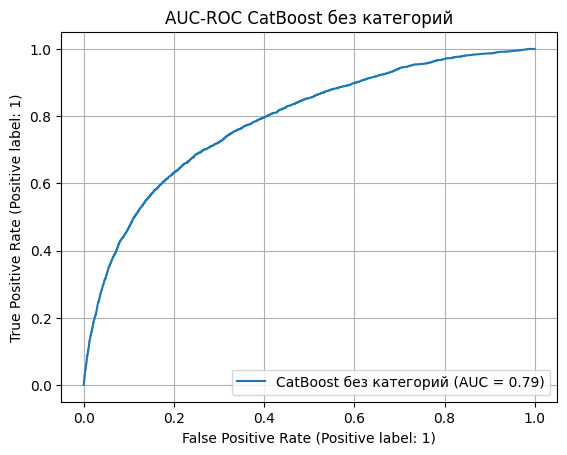

In [76]:
model_roc_auc = roc_auc_score(y_test, model_numerical_probabilities[:,1])
print(f"AUC-ROC (площадь под кривой ошибок) модели CatBoost без категориальных признаков: {model_roc_auc}")
RocCurveDisplay.from_predictions(y_test, model_numerical_probabilities[:,1], name="CatBoost без категорий")
plt.title("AUC-ROC CatBoost без категорий")
plt.grid()
plt.show()

In [77]:
model_numerical.get_feature_importance(prettified=True)

,Feature Id,Importances
0,NumberOfTime30-59DaysPastDueNotWorse,43.349963
1,age,24.888956
2,NumberOfOpenCreditLinesAndLoans,16.324223
3,MonthlyIncome,10.845288
4,NumberOfDependents,4.591569


Мы видим, что показатели модели не улучшились, из чего следует, что улучшение метрик необходимо искать другими способами.

### Изменения размера выборки для обучения

Первоначально набор данных был разделен на выбору для обучения и выборку для тестирования в соотношении 70% для обучения и 30% для тестирования. Мы можем изменить это распределение и проверить, как это сказалось на метриках модели. Увеличим размер выборки для обучения до 80%.

In [78]:
# Заново разобъем набор данных на набор для тестирования и набор для обучения.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

# Определить индексы столбцов, под которыми находятся категориальные признаки.
categorical_features_indices = np.where(x.dtypes == object)[0]

# Сгруппируем наборы данных для тестирования и обучения.
train_pool = Pool(x_train, y_train, cat_features=categorical_features)
test_pool = Pool(x_test, y_test, cat_features=categorical_features)

# Инициализировать и обучить модель CatBoost с заданными выше параметрами.
model = CatBoostClassifier(**params)
print("AUC модели CatBoost после увеличения выборки для обучения:")
model.fit(
    train_pool,
    eval_set=test_pool,
    verbose=False,
    plot=False
)

AUC модели CatBoost после увеличения выборки для обучения:

bestTest = 0.7920398204
bestIteration = 142

Shrink model to first 143 iterations.


In [79]:
# Получить предсказания модели и вероятности.
model_predictions = model.predict(x_test)
model_probabilities = model.predict_proba(x_test)

# Построить классификационный отчет.
model_report = classification_report(y_test, model_predictions)
print(f"Основные метрики модели CatBoost:\n{model_report}")

Основные метрики модели CatBoost:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     27973
           1       0.45      0.04      0.06      2027

    accuracy                           0.93     30000
   macro avg       0.69      0.52      0.51     30000
weighted avg       0.90      0.93      0.90     30000



Увеличение размера выборки для обучение дало незначительное улучшение метрик, поэтому будем применять данный подход и далее.

### Балансировка классов

Одной из основных проблем исходного набора данных является существенный дисбаланс классов целевого признака: 93% составляет класс 0, 7% - класс 1. Применим для балансировки классов параметр `auto_class_weights` класса `CatBoostClassifier`. Параметр `auto_class_weights` может иметь два ненулевых значения: `Balanced` и `SqrtBalanced`. Применим оба и сравним результаты.

In [80]:
for method in ("SqrtBalanced", "Balanced"):
  params.update({"auto_class_weights": method})
  model = CatBoostClassifier(**params)
  print(f"AUC модели CatBoost с применением метода балансировки классов {method}: ")
  model.fit(
      train_pool,
      eval_set=test_pool,
      verbose=False,
      plot=False
  )
  # Получить предсказания модели и вероятности.
  model_predictions = model.predict(x_test)
  model_probabilities = model.predict_proba(x_test)

  # Построить классификационный отчет.
  model_report = classification_report(y_test, model_predictions)
  print(
      "\nОсновные метрики модели CatBoost с применением "
      f"метода балансировки классов {method}:\n{model_report}"
)

AUC модели CatBoost с применением метода балансировки классов SqrtBalanced: 

bestTest = 0.7925756373
bestIteration = 145

Shrink model to first 146 iterations.

Основные метрики модели CatBoost с применением метода балансировки классов SqrtBalanced:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     27973
           1       0.32      0.33      0.33      2027

    accuracy                           0.91     30000
   macro avg       0.64      0.64      0.64     30000
weighted avg       0.91      0.91      0.91     30000

AUC модели CatBoost с применением метода балансировки классов Balanced: 

bestTest = 0.7924961329
bestIteration = 136

Shrink model to first 137 iterations.

Основные метрики модели CatBoost с применением метода балансировки классов Balanced:
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     27973
           1       0.18      0.67      0.29      2027

    accuracy   

В соответствии с условиями задачи нам важно улучшать показатель `Recall` - определять максимальное количество "плохих" заемщиков. В текущих экономических и геополитических условиях кредитор должен снижать риски кредитования - то есть, переходить к более консервативной кредитной политике или снижать размер кредитного портфеля. В данном контексте можно не придавать большого значения риску не выдать кредит "хорошему" заемщику, но повысить значение риска выдать кредит "плохому" заемщику. Поэтому мы веберем метод балансировки весов классов `Balanced` как дающий большее число обнаружений "плохих" заемщиков.

###  Снижение дискриминационного порога

По умолчанию CatBoost устанавливает значение дискриминационного порога раным 0.5. Это значение можно интепретировать как вероятность заданного исхода классификации. Снижение дискриминационного порога увеличит количество ошибок классификации, но позволит обнаружить еще больше "плохих" заемщиков.

In [81]:
for threshold in (0.1, 0.2, 0.3, 0.4, 0.5):
  model.set_probability_threshold(threshold)
  model_predictions = model.predict(x_test)
  model_probabilities = model.predict_proba(x_test)
  model_report = classification_report(y_test, model_predictions)
  print(
      "\nОсновные метрики классификатора CatBoost со значением "
      f"дискриминационного порога {threshold}:\n{model_report}"
  )


Основные метрики классификатора CatBoost со значением дискриминационного порога 0.1:
              precision    recall  f1-score   support

           0       0.99      0.02      0.05     27973
           1       0.07      1.00      0.13      2027

    accuracy                           0.09     30000
   macro avg       0.53      0.51      0.09     30000
weighted avg       0.93      0.09      0.05     30000


Основные метрики классификатора CatBoost со значением дискриминационного порога 0.2:
              precision    recall  f1-score   support

           0       0.99      0.20      0.33     27973
           1       0.08      0.98      0.15      2027

    accuracy                           0.25     30000
   macro avg       0.54      0.59      0.24     30000
weighted avg       0.93      0.25      0.31     30000


Основные метрики классификатора CatBoost со значением дискриминационного порога 0.3:
              precision    recall  f1-score   support

           0       0.98      0.40

Снижение дискриминационного порога повышает Recall, но также повышает и количество ошибок классификации.

### Изменение стратегии обработки данных

На этапе предварительной подготовки данных мы удалили ряд факторных признаков. Возможно, что модель CatBoost посчитала бы эти признаки значимыми, поэтому переобучим модель с учетом этих признаков. Также ранее мы обрабатывали пропуски. Попробуем изменить стратегию и не обрабатывать пропуски.

In [82]:
data = read_sql_data()
y = data[TARGET_FEATURE]
x = data.drop(columns=[TARGET_FEATURE])
categorical_features = [column for column in x.columns if x[column].dtype == "object"]

Заново обучим модель классификатора, используя параметры, полученные на предыдущих итерациях эксперимента.

In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)
train_pool = Pool(x_train, y_train, cat_features=categorical_features)
test_pool = Pool(x_test, y_test, cat_features=categorical_features)
print("AUC модели CatBoost без предварительной подготовки данных:")
model.fit(
  train_pool, 
  eval_set=test_pool, 
  verbose=False, 
  plot=False
)

AUC модели CatBoost без предварительной подготовки данных:

bestTest = 0.8644953758
bestIteration = 161

Shrink model to first 162 iterations.


In [89]:
model_predictions = model.predict(x_test)
model_probabilities = model.predict_proba(x_test)
model_report = classification_report(y_test, model_predictions)
print(
  "Основные метрики классификатора CatBoost "
  f"без предварительной подготовки данных:\n{model_report}"
)

Основные метрики классификатора CatBoost без предварительной подготовки данных:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27951
           1       0.22      0.77      0.35      2049

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.85     30000



Можно сделать вывод, что модель, обученная на неподготовленных данных, демонстирирует более высокие метрики, следовательно она будет выбрана для дальнейшего развертывания.

### Итоги оптимизации

Визуализируем основные метрики и атрибуты выбранной модели.

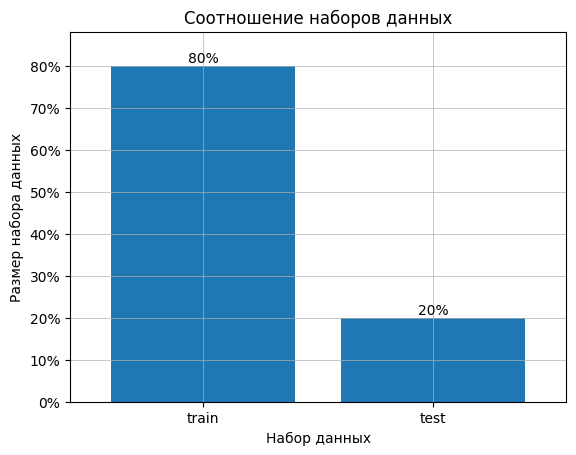

In [90]:
fig, ax = plt.subplots()
sets = ["train", "test"]
test_size = len(x_test)/len(x)
counts = [1 - test_size, test_size]
ax.bar(sets, counts)
ax.grid(linewidth=0.5)
ax.bar_label(ax.containers[0], fmt="{:.0%}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
ax.set_xlabel("Набор данных")
ax.set_ylabel("Размер набора данных")
ax.set_title("Соотношение наборов данных")
plt.xticks(rotation="horizontal")
plt.margins(0.1, 0.1)
plt.show()

Основные метрики модели градиентного бустинга CatBoost.

In [91]:
for key, value in params.items():
  print(f"{key}: {value}")

iterations: 200
learning_rate: 0.1
loss_function: Logloss
eval_metric: AUC
random_seed: 42
logging_level: Verbose
use_best_model: True
auto_class_weights: Balanced


Основные метрики модели градиентного бустинга CatBoost.

In [92]:
model_report = classification_report(y_test, model_predictions)
print(f"Основные метрики модели градиентного бустинга CatBoost:\n{model_report}")

Основные метрики модели градиентного бустинга CatBoost:
              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27951
           1       0.22      0.77      0.35      2049

    accuracy                           0.80     30000
   macro avg       0.60      0.79      0.61     30000
weighted avg       0.93      0.80      0.85     30000



Площадь под кривой ошибок.

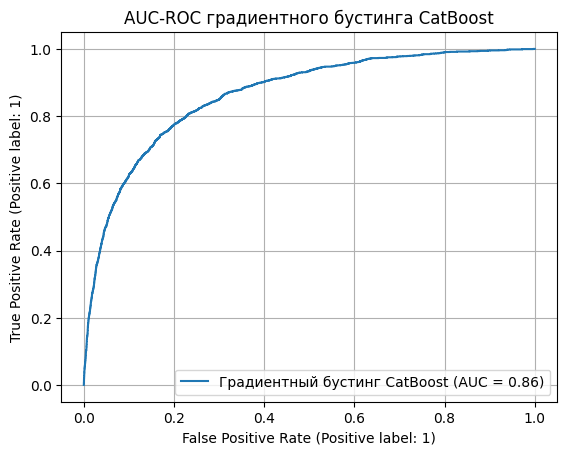

In [93]:
RocCurveDisplay.from_predictions(y_test, model_probabilities[:,1], name="Градиентный бустинг CatBoost")
plt.title("AUC-ROC градиентного бустинга CatBoost")
plt.grid()
plt.show()

Матрица ошибок.

Матрица ошибок (confusion_matrix) модели градиентного бустинга CatBoost:


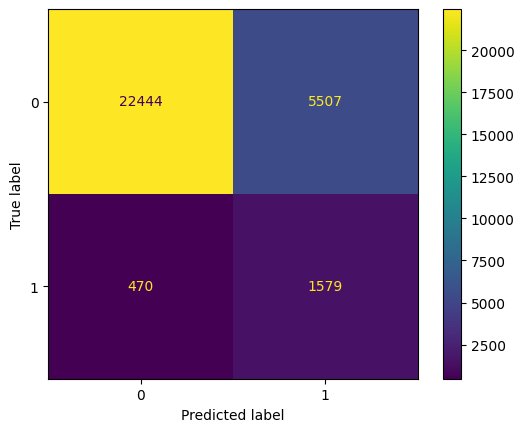

In [94]:
model_confusion = confusion_matrix(y_test, model_predictions, labels=decision_tree.classes_)
print(f"Матрица ошибок (confusion_matrix) модели градиентного бустинга CatBoost:")
model_confusion_display = ConfusionMatrixDisplay(model_confusion, display_labels=model.classes_)
model_confusion_display.plot(values_format="")
plt.show()

Визуализация решающего дерева.

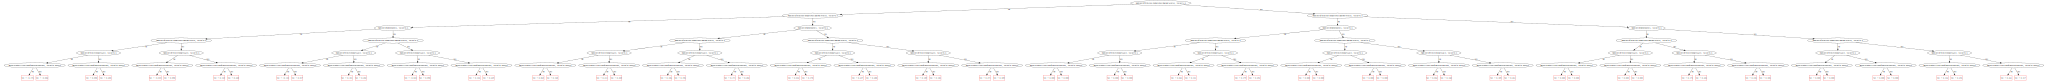

In [95]:
model.plot_tree(tree_idx=0, pool=train_pool)

Веса признаков.

In [96]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,RevolvingUtilizationOfUnsecuredLines,29.959086
1,DebtRatio,11.486642
2,NumberOfTime30-59DaysPastDueNotWorse,10.427691
3,age,10.006073
4,MonthlyIncome,9.549953
5,NumberOfOpenCreditLinesAndLoans,7.953840
6,NumberOfTimes90DaysLate,7.429748
7,NumberOfTime60-89DaysPastDueNotWorse,4.358227
8,RealEstateLoansOrLines,3.484718
9,NumberOfDependents,2.779229


Отобразим влияние признков на предсказание при помощи значений Шэпли. Значения шэпли позволяют понять, какие признаки вносят наибольший вклад в предсказания модели и как их комбинации влияют на результат. 

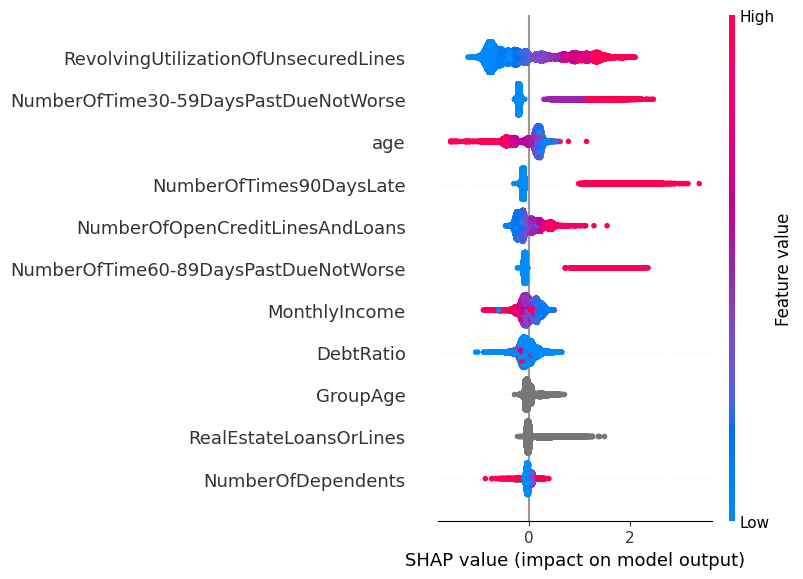

In [97]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train)

## Сохранение модели

Сохраним модель CatBoost в формате JSON.

In [98]:
model.save_model("catboost_model.json", format="json")